### Extract timing info from running MACHINA's pmh_ti on all m5 and m8 simulated data

In [1]:
import os
import pandas as pd

repo_dir = os.path.join(os.getcwd(), "../../../")
metient_results_dir = '/data/morrisq/divyak/data/metient_prediction_results/'
mach_sim_dir = os.path.join(repo_dir, "metient/test/machina_simulated_data")
mach_time_fn = os.path.join(mach_sim_dir, "pmh_ti_timing_8cores_11232022.txt")

DATE = "07052024"
PARAMS = "calibrate_wip"
CALIBRATE = True

MIG_TYPES = ["mS", "M", "S", "R"]
cols = ["seed", "site", "mig_type", "time"]

data = []
with open(mach_time_fn, "r") as f:
    for line in f:
        if "Runtime" in line:
            items = line.split()
            seed = int(items[3][:-1])
            mig_type = items[5][:-1]
            site = items[8][:-1]
            time = float(items[9])
            data.append([seed, site, mig_type, time])
machina_time_df = pd.DataFrame(data, columns=cols)
machina_time_df

,seed,site,mig_type,time
0,0,m5,mS,17.906445
1,10,m5,mS,11.254564
2,12,m5,mS,6.827857
3,2,m5,mS,7.802355
4,3,m5,mS,19.485894
...,...,...,...,...
74,383,m8,R,1311.944181
75,394,m8,R,257.018207
76,905,m8,R,266.204274
77,981,m8,R,805.483616


### Extract timing info from running Metient


In [2]:
import glob
import json

data = []
num_runs = 5
tot_sim_trees = 1647
batch_sizes = [64, 256, 1024]

for bs in batch_sizes:
    for run in range(1,num_runs+1):
        stat_fns = glob.glob(os.path.join(metient_results_dir,f'predictions_batch_exp_bs{bs}_{PARAMS}_r{run}_{DATE}','perf_stats*'))
        ct = 0
        print(bs, run, len(stat_fns))
        for stat_fn in stat_fns:
            with open(stat_fn, "r") as f:
                for line in f:
                    #print(line)
                    items = line.strip().split()
                    data.append([bs, items[0], items[1], int(items[2]), int(items[3]), float(items[5])])
                    ct += 1
        assert(ct==tot_sim_trees)

cols = ["batch_size", "site", "mig_type", "seed", "tree_num", "time_with_plotting"]
metient_df = pd.DataFrame(data, columns=cols)
# Group by 'Category' and apply the aggregation functions
agg_rules = {"time_with_plotting":"mean"}
metient_df = metient_df.groupby(["batch_size",'site', 'mig_type', 'seed', 'tree_num']).agg(agg_rules).reset_index()
metient_df

64 1 80
64 2 80
64 3 80
64 4 80
64 5 80
256 1 80
256 2 80
256 3 80
256 4 80
256 5 80
1024 1 80
1024 2 80
1024 3 80
1024 4 80
1024 5 80


,batch_size,site,mig_type,seed,tree_num,time_with_plotting
0,64,m5,M,76,0,2.785528
1,64,m5,M,76,1,2.218844
2,64,m5,M,76,2,2.326368
3,64,m5,M,76,3,2.192518
4,64,m5,M,209,0,3.074611
...,...,...,...,...,...,...
4936,1024,m8,mS,12,103,4.032083
4937,1024,m8,mS,12,104,4.564179
4938,1024,m8,mS,12,105,4.505469
4939,1024,m8,mS,12,106,4.132682


In [3]:
# Get number of trees per site/mig_type/seed combo
tree_nums_df = metient_df[metient_df["batch_size"]==64].groupby(['site', 'mig_type', 'seed']).size().reset_index(name='counts')
tree_nums_df

,site,mig_type,seed,counts
0,m5,M,76,4
1,m5,M,209,12
2,m5,M,473,80
3,m5,M,512,12
4,m5,M,534,24
...,...,...,...,...
75,m8,mS,7,2
76,m8,mS,8,2
77,m8,mS,9,1
78,m8,mS,10,4


### If timing calibrate mode, need to add the extra time needed for calibration and reordering/saving trees

In [4]:

def add_cal_time(row, bs_to_mig_type_to_avg_cal_time):
    cal_time = bs_to_mig_type_to_avg_cal_time[row['batch_size']][row['mig_type']]
    return row['time_with_plotting'] + cal_time
    
if CALIBRATE == True:
    bs_to_mig_type_to_avg_cal_time = {bs:{m:[] for m in MIG_TYPES} for bs in batch_sizes}
    for bs in batch_sizes:
        for run in range(1,num_runs+1):
            cal_time_fn = os.path.join(metient_results_dir,f'predictions_batch_exp_bs{bs}_{PARAMS}_r{run}_{DATE}','mig_type_to_calibration_time.json')
            with open(cal_time_fn, 'r') as f:
                d = json.load(f)
                print(d)
                for k,v in d.items():
                    bs_to_mig_type_to_avg_cal_time[bs][k].append(v)
    for bs in bs_to_mig_type_to_avg_cal_time:
        for mig_type in bs_to_mig_type_to_avg_cal_time[bs]:
            times = bs_to_mig_type_to_avg_cal_time[bs][mig_type]
            num_trees = tree_nums_df[tree_nums_df['mig_type']==mig_type]['counts'].sum()
            # Take the average of calibration time needed for this migration type across all runs, 
            # and then divide by  the number of trees in that migration type to add to each tree
            bs_to_mig_type_to_avg_cal_time[bs][mig_type] = (sum(times)/len(times))/num_trees
metient_df['time_with_plotting'] = metient_df.apply(lambda row: add_cal_time(row, bs_to_mig_type_to_avg_cal_time), axis=1)
bs_to_mig_type_to_avg_cal_time

{'M': 1347.788424, 'mS': 414.41130899999996, 'R': 1042.1502269999999, 'S': 1565.104151}
{'M': 1263.1737879999998, 'mS': 374.557276, 'R': 961.952386, 'S': 1501.944428}
{'M': 1232.2891200000001, 'mS': 377.87440599999996, 'R': 950.368279, 'S': 1419.080448}
{'M': 1255.5790150000003, 'mS': 369.734482, 'R': 954.5891730000001, 'S': 1499.96901}
{'M': 1219.5354889999999, 'mS': 352.012432, 'R': 957.84511, 'S': 1485.276716}
{'M': 1864.2780579999999, 'mS': 865.815353, 'R': 1571.8092270000002, 'S': 2754.360283}
{'M': 2032.057627, 'mS': 897.6489669999999, 'R': 1613.100964, 'S': 3169.9562260000002}
{'M': 2002.85491, 'mS': 889.3257339999999, 'R': 1546.895123, 'S': 3158.483475}
{'M': 2061.579409, 'mS': 937.8590770000001, 'R': 1655.020702, 'S': 3180.1203470000005}
{'M': 1985.609864, 'mS': 911.353153, 'R': 1611.4903339999998, 'S': 3294.005275}
{'M': 2901.0193709999994, 'mS': 1575.714493, 'R': 2476.958229, 'S': 5851.137252999999}
{'M': 2931.756577, 'mS': 1588.3671699999998, 'R': 2472.48016, 'S': 6121.3343

{64: {'mS': 2.208877081871345,
  'M': 2.537496319678715,
  'S': 2.840826902281369,
  'R': 2.153497865044248},
 256: {'mS': 5.2654997473684215,
  'M': 3.9945300674698796,
  'S': 5.91518083878327,
  'R': 3.5390780309734513},
 1024: {'mS': 9.452132626900585,
  'M': 6.090048479518072,
  'S': 11.169909577946768,
  'R': 5.42870832699115}}

In [5]:
import fnmatch

# Get number of clusters (tree vertices to label) and number of anatomical sites per site/mig_type/seed combo
sims_dir = os.path.join(repo_dir, "metient/data/machina_sims")
og_sims_dir = '/data/morrisq/divyak/projects/machina/data/sims/'
data = []
for site in ["m5", "m8"]:
    for mig_type in ["mS", "M", "S", "R"]:
        site_mig_type_dir = os.path.join(sims_dir, site, mig_type)
        seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
        seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
        cluster_input_dir = os.path.join(sims_dir, f"{site}_clustered_input")
        for seed in seeds:
            fn = os.path.join(cluster_input_dir, f"cluster_{mig_type}_seed{seed}.txt")
            num_lines = sum(1 for _ in open(fn))
            
            fn = os.path.join(og_sims_dir, site, mig_type, f"T_seed{seed}.labeling")
            sites = set()
            with open(fn) as f:
                for line in f:
                    sites.add(line.strip().split()[1])
            data.append([seed, site, mig_type, num_lines, len(sites)])
            
cols = ["seed", "site", "mig_type", "clusters", "sites"]
cluster_num_df = pd.DataFrame(data, columns=cols)
cluster_num_df

,seed,site,mig_type,clusters,sites
0,0,m5,mS,13,5
1,7,m5,mS,9,5
2,4,m5,mS,12,5
3,9,m5,mS,6,5
4,8,m5,mS,10,5
...,...,...,...,...,...
75,394,m8,R,15,9
76,981,m8,R,22,9
77,383,m8,R,17,8
78,30342,m8,R,11,8


In [6]:
# Collect timing data
# TODO: don't use summed data for machina once that's collected

def get_search_space(num_sites, num_nodes):
    return (num_sites**(num_nodes-1))

timing_data = []
for site in ["m5", "m8"]:
    for mig_type in MIG_TYPES:
        site_mig_type_dir = os.path.join(sims_dir, site, mig_type)
        seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
        seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
        for seed in seeds:
            
            num_clusters = cluster_num_df[(cluster_num_df['site']==site) & (cluster_num_df['mig_type']==mig_type) & (cluster_num_df['seed']==seed)]['clusters'].item()
            num_sites = cluster_num_df[(cluster_num_df['site']==site) & (cluster_num_df['mig_type']==mig_type) & (cluster_num_df['seed']==seed)]['sites'].item()
            search_space = get_search_space(num_sites, num_clusters)
            num_trees = tree_nums_df[(tree_nums_df['site']==site) & (tree_nums_df['mig_type']==mig_type) & (tree_nums_df['seed']==int(seed))]['counts'].item()
        
            for bs in batch_sizes:
                bs_set = metient_df[metient_df["batch_size"]==bs]
                all_trees_df = bs_set[(bs_set['site']==site) & (bs_set['mig_type']==mig_type) & (bs_set['seed']==int(seed))]
                for i in all_trees_df['tree_num'].unique():
                    met_time = all_trees_df[all_trees_df['tree_num']==i]['time_with_plotting'].item()
                    timing_data.append([site, mig_type, seed,num_clusters, search_space, met_time, f"Metient-{bs}"])

            # TODO: figure out why this isn't running on MACHINA
            if seed == '172' and site == "m8" and mig_type == "M":
                continue
              
            sum_mach_time = machina_time_df[(machina_time_df['site']==site) & (machina_time_df['mig_type']==mig_type) & (machina_time_df['seed']==int(seed))]['time'].item()
            avg_mach_time = sum_mach_time/float(num_trees)

            timing_data.append([site, mig_type, seed,num_clusters, search_space, avg_mach_time, "MACHINA"])
            
timing_df = pd.DataFrame(timing_data, columns=["Sites", "Mig type", "Seed", "Number of tree nodes", "Size of search space", "CPU wall-time (s)", "Method"])
timing_df

,Sites,Mig type,Seed,Number of tree nodes,Size of search space,CPU wall-time (s),Method
0,m5,mS,0,13,244140625,5.151054,Metient-64
1,m5,mS,0,13,244140625,4.446418,Metient-64
2,m5,mS,0,13,244140625,8.185944,Metient-256
3,m5,mS,0,13,244140625,7.634095,Metient-256
4,m5,mS,0,13,244140625,13.185113,Metient-1024
...,...,...,...,...,...,...,...
5015,m8,R,157,21,672749994932560009201,13.484104,Metient-1024
5016,m8,R,157,21,672749994932560009201,12.288105,Metient-1024
5017,m8,R,157,21,672749994932560009201,12.702936,Metient-1024
5018,m8,R,157,21,672749994932560009201,12.283333,Metient-1024


In [7]:
timing_df[timing_df['CPU wall-time (s)']>100]

,Sites,Mig type,Seed,Number of tree nodes,Size of search space,CPU wall-time (s),Method
2392,m8,M,35,19,150094635296999121,113.497239,MACHINA
2429,m8,M,243,18,16677181699666569,221.187329,MACHINA
4818,m8,R,981,22,109418989131512359209,100.685452,MACHINA
5019,m8,R,157,21,672749994932560009201,147.144492,MACHINA


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654), (0.99609375, 0.56640625, 0.37109375)]
['Metient-64', 'Metient-64 CI (SD)', 'Metient-256', 'Metient-256 CI (SD)', 'Metient-1024', 'Metient-1024 CI (SD)', 'MACHINA', 'MACHINA CI (SD)']
(-44.958225307943096, 214.73297745288755)


<Figure size 400x400 with 0 Axes>

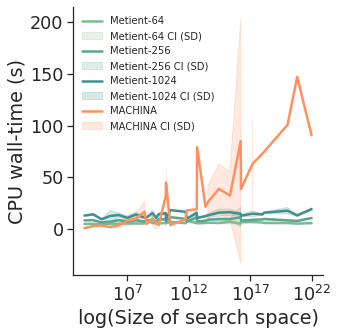

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

methods = ["Metient-64", "Metient-256", "Metient-1024", "MACHINA"]

colors = sns.color_palette("crest")
colors = colors[:len(methods)-1]
colors.append((0.99609375, 0.56640625, 0.37109375))
print(colors)


sns.set(style='ticks', rc={'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 15,  "axes.linewidth":2})
sns.set_palette(sns.color_palette(colors))
    
fig = plt.figure(figsize=(2, 2), dpi=200)
with sns.plotting_context("notebook", font_scale=1.6):

    g = sns.relplot(
        data=timing_df, x="Size of search space", y="CPU wall-time (s)",
        dashes=False, linewidth=2.5,
        hue="Method", kind="line",ci='sd',style="Method",  legend=False,
    )


    (g.set_axis_labels("log(Size of search space)", "CPU wall-time (s)")
      .set_titles("boop")
      .tight_layout(w_pad=0))

    #     g = sns.scatterplot(
    #         data=timing_df, x="Size of Search Space", y="CPU Wall-time (s)",
    #         hue="Method",legend=False,
    #     )
    #     g.spines['top'].set_visible(False)
    #     g.spines['right'].set_visible(False)

    labels = []
    for i,method in enumerate(methods):
        labels.append(method)
        labels.append(f"{method} CI (SD)")
    print(labels)

    plt.xscale("log")
    #plt.yscale("log")

    print(plt.ylim())

    #plt.xlim(0, 30)
    plt.legend(title='', loc='upper left', fontsize=15, labels=labels, prop={'size': 10}, frameon=False)
    plt.show()

fig = g.fig
fig.savefig(os.path.join(repo_dir, "metient/test/output_plots", f"timing_benchmarks_search_space_{PARAMS}_{DATE}.png"), dpi=600) 


In [9]:
timing_df[(timing_df['Method']=='Metient-1024')&(timing_df['CPU wall-time (s)']<10)]

,Sites,Mig type,Seed,Number of tree nodes,Size of search space,CPU wall-time (s),Method
136,m5,M,209,9,390625,9.566773,Metient-1024
137,m5,M,209,9,390625,9.555828,Metient-1024
138,m5,M,209,9,390625,9.709105,Metient-1024
139,m5,M,209,9,390625,9.536338,Metient-1024
140,m5,M,209,9,390625,9.294676,Metient-1024
...,...,...,...,...,...,...,...
1790,m5,R,17,13,2176782336,9.505342,Metient-1024
1792,m5,R,17,13,2176782336,9.470515,Metient-1024
1796,m5,R,17,13,2176782336,9.651247,Metient-1024
4604,m8,R,10157,17,281474976710656,9.954865,Metient-1024


In [18]:
timing_df[timing_df["CPU wall-time (s)"]==221.1873294705]

,Sites,Mig type,Seed,Number of tree nodes,Size of search space,CPU wall-time (s),Method
2429,m8,M,243,18,16677181699666569,221.187329,MACHINA


In [19]:
timing_df[(timing_df["Sites"]=="m8")&(timing_df["Mig type"]=="M")&(timing_df["Seed"]=="243")]

,Sites,Mig type,Seed,Number of tree nodes,Size of search space,CPU wall-time (s),Method
2393,m8,M,243,18,16677181699666569,6.735003,Metient-64
2394,m8,M,243,18,16677181699666569,5.443197,Metient-64
2395,m8,M,243,18,16677181699666569,5.053863,Metient-64
2396,m8,M,243,18,16677181699666569,5.022746,Metient-64
2397,m8,M,243,18,16677181699666569,5.070142,Metient-64
2398,m8,M,243,18,16677181699666569,5.363404,Metient-64
2399,m8,M,243,18,16677181699666569,5.206641,Metient-64
2400,m8,M,243,18,16677181699666569,5.376548,Metient-64
2401,m8,M,243,18,16677181699666569,5.161623,Metient-64
2402,m8,M,243,18,16677181699666569,5.161176,Metient-64


In [12]:
cluster_num_df[(cluster_num_df['site']=='m8') & (cluster_num_df['mig_type']=='M') & (cluster_num_df['seed']=='243')]


,seed,site,mig_type,clusters,sites
53,243,m8,M,18,9


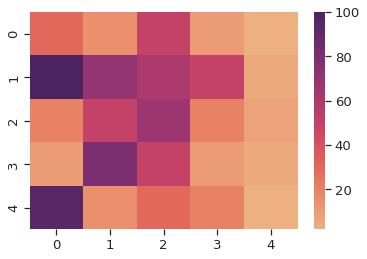

In [13]:
data=[[30,15,50,10,2],
      [100,70,60,50,5],
      [20,50,66,20,7],
      [10,80,50,10,5],
      [95,15,30,20,2]]
with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.heatmap(data, cmap="flare")
    plt.show()
    fig = g.get_figure()
    fig.savefig("heatmap.png", dpi=600) 